In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 32.9 MB/s eta 0:

# Необходимые импорты

In [2]:
import os
import random
import torch
import pandas as pd 
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized

# Зафиксируем важные параметры

In [3]:
N_THREADS = 4
N_FOLDS = 7
RANDOM_STATE = 52
TIMEOUT = 36000
TARGET_NAME = 'target'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(RANDOM_STATE)

In [5]:
torch.set_num_threads(N_THREADS)

# 1. Обучение без погодных данных

In [6]:
train = pd.read_csv('/kaggle/input/trainv2/train_ver2.csv')
train.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

                                                   9  vegetation   2015  2016  \
0  [-1.4386533 -4.25053   -6.1608253 -1.1426252  ...         110  140.0   NaN   
1  [ 3.6313097   0.65917706  6.95152    -1.058237...         113  130.0   NaN   

    2017   2019   2020   2021  2022  2023  
0  124.0  115.0  121.0  117.0   NaN   NaN  
1    NaN   99.0  143.0    NaN   NaN   NaN  

[2 rows x 50 columns]

In [7]:
train.columns

Index(['Sample', '0/0_homozygous_count', '0/1_homozygous_count',
       '1/1_homozygous_count', './._homozygous_count', '1/2_homozygous_count',
       '0/2_homozygous_count', '2/2_homozygous_count', '1/3_homozygous_count',
       '2/3_homozygous_count', '0/3_homozygous_count', '3/3_homozygous_count',
       'chromosome_20_variant_count', 'chromosome_20_variant_ratio',
       'read_depth_mean', 'read_depth_median', 'read_depth_std',
       'read_depth_quartile1', 'read_depth_quartile3', 'pl_mean',
       'pl_variance', '1', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9', 'vegetation',
       '2015', '2016', '2017', '2019', '2020', '2021', '2022', '2023'],
      dtype='object')

In [8]:
id_vars = [
    'Sample', '0/0_homozygous_count', '0/1_homozygous_count',
    '1/1_homozygous_count', './._homozygous_count', '1/2_homozygous_count',
    '0/2_homozygous_count', '2/2_homozygous_count', '1/3_homozygous_count',
    '2/3_homozygous_count', '0/3_homozygous_count', '3/3_homozygous_count',
    'chromosome_20_variant_count', 'chromosome_20_variant_ratio',
    'read_depth_mean', 'read_depth_median', 'read_depth_std',
    'read_depth_quartile1', 'read_depth_quartile3', 'pl_mean',
    'pl_variance', '1', '10', '11', '12', '13', '14', '15', '16', '17',
    '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9', 'vegetation'
]

year_columns = ['2015', '2016',	'2017', '2019', '2020', '2021', '2022', '2023']

df_melted = train.melt(
    id_vars=id_vars, 
    value_vars=year_columns, 
    var_name='year', 
    value_name='target'
)

In [9]:
df_filtered = df_melted.dropna(subset=['target']).reset_index(drop=True)
df_filtered['year'] = df_filtered['year'].astype(int)
df_filtered.shape

(359, 44)

In [10]:
df_filtered.to_csv('train_filtered.csv', index=False)

## Разделим эмбеддинги на отдельные фичи

In [11]:
X = df_filtered.drop('target', axis=1)
y = df_filtered.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [12]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble
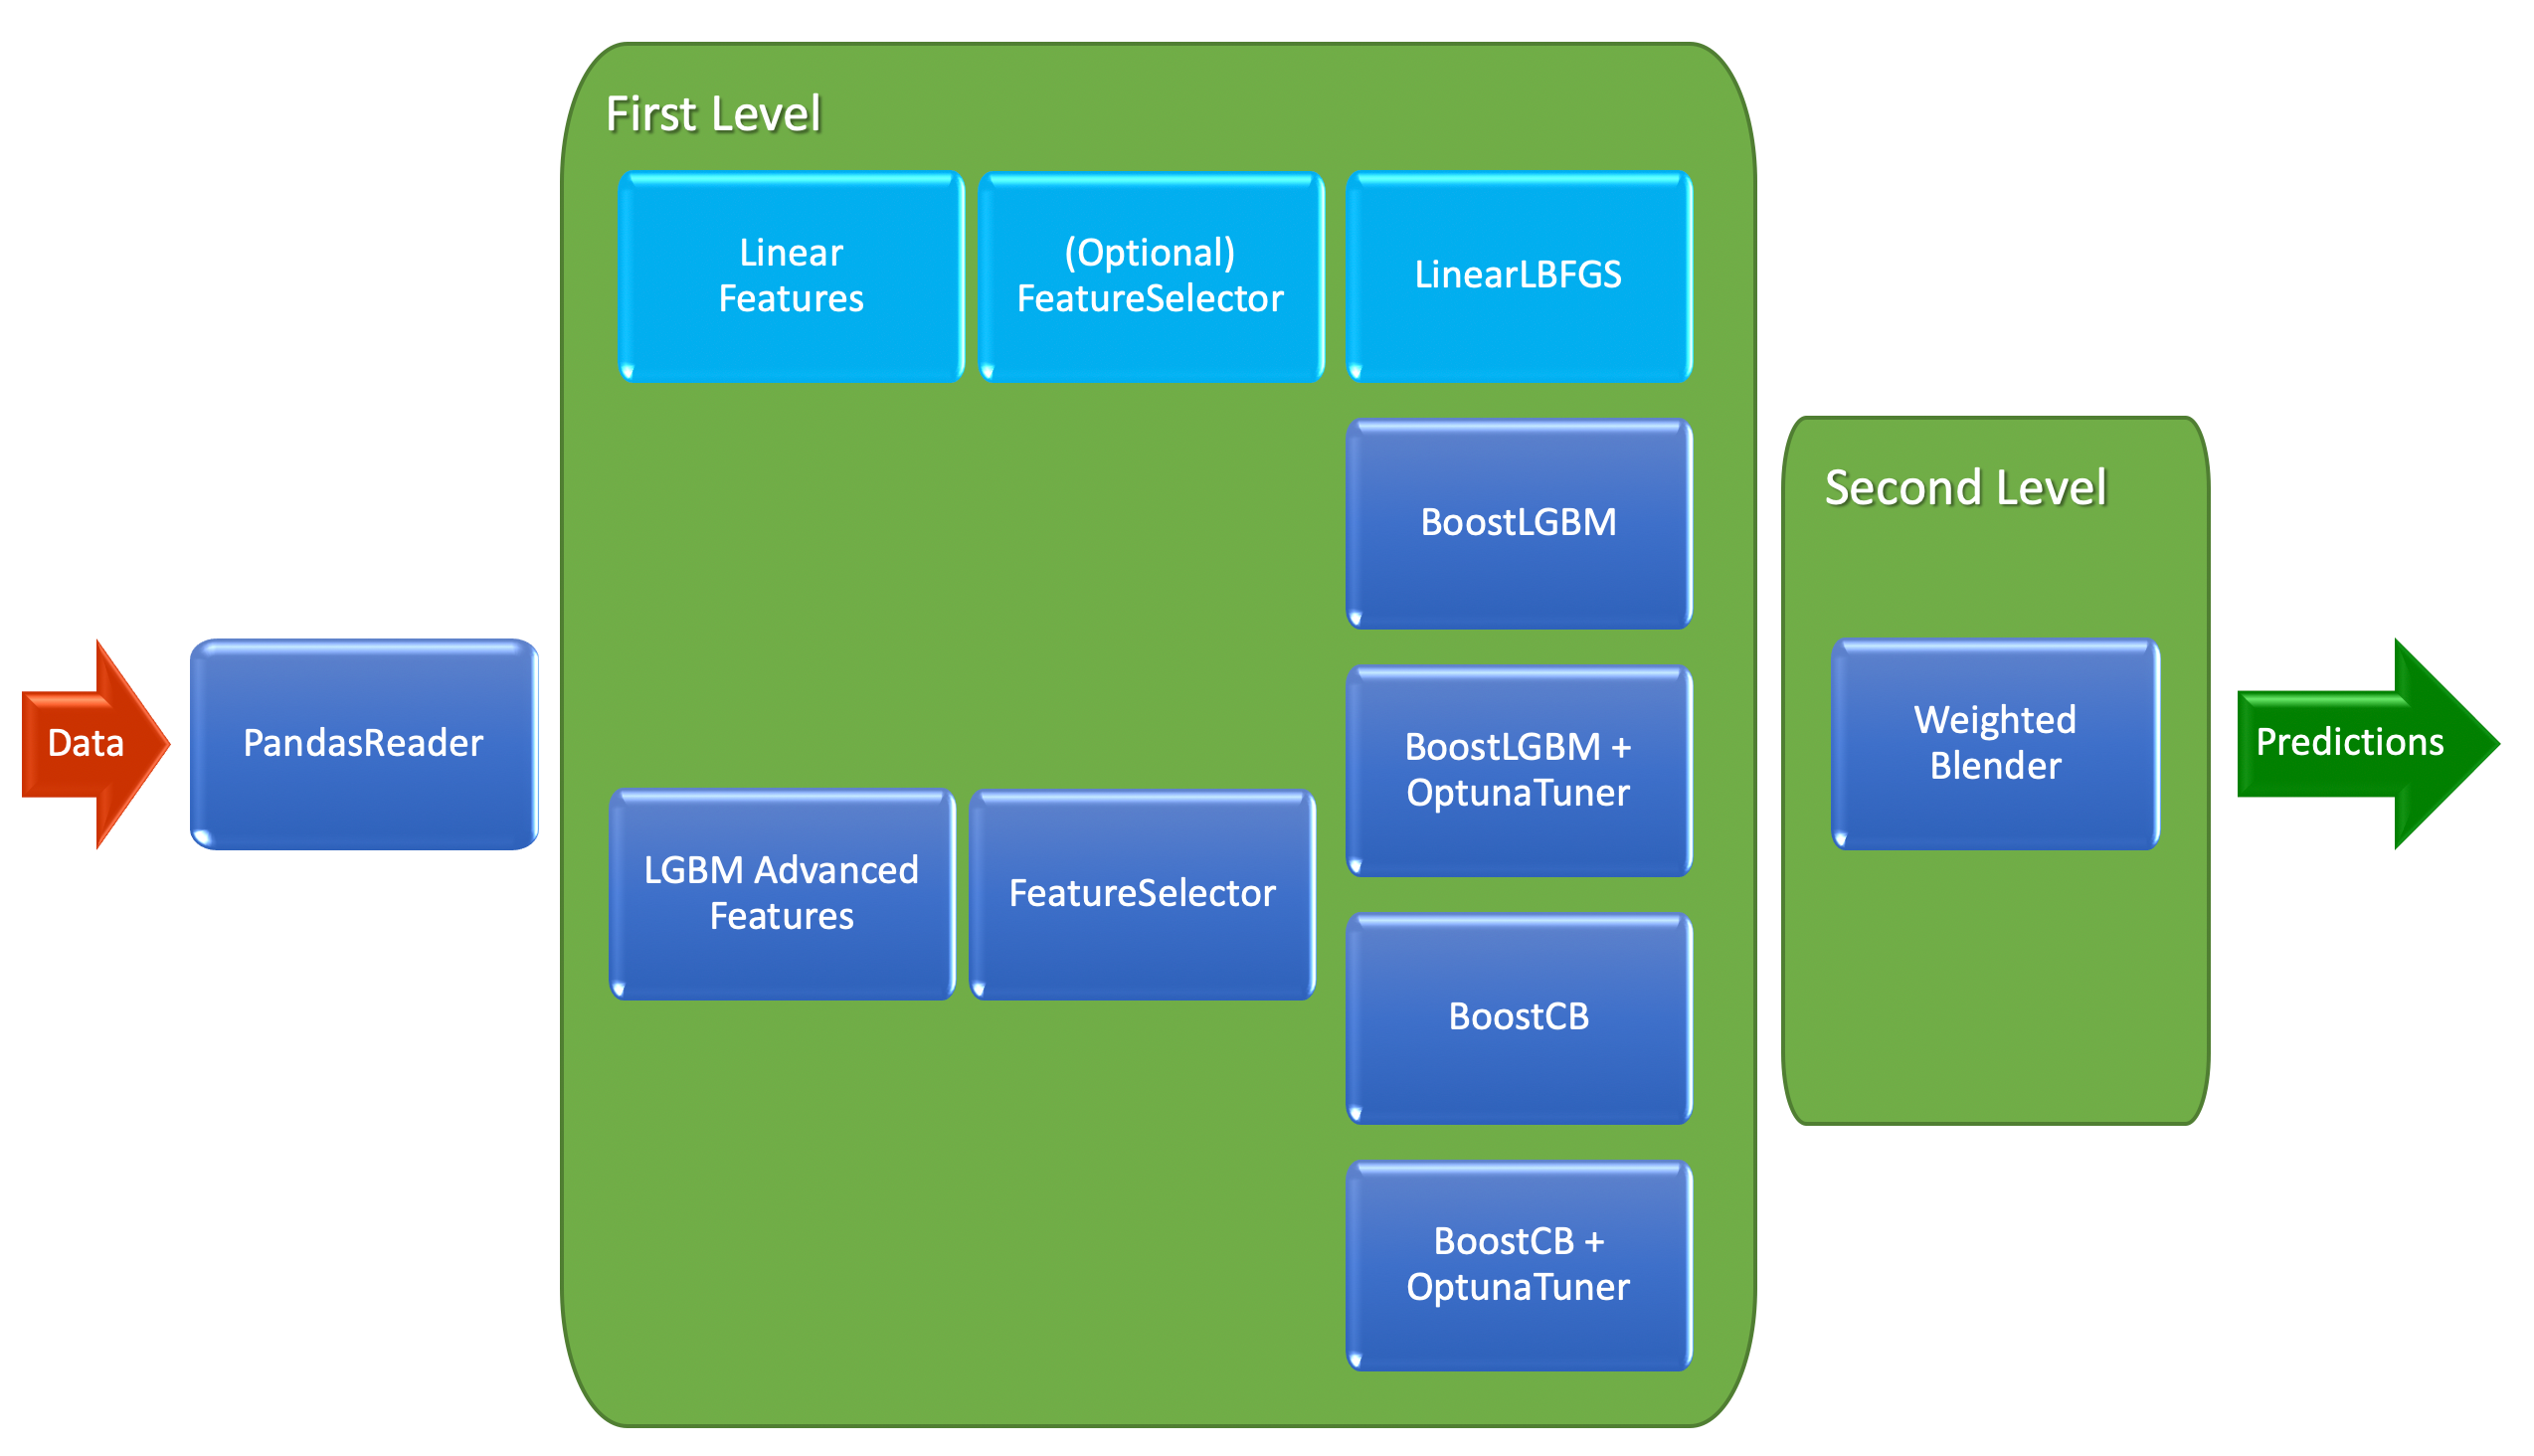

In [13]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [14]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[17:52:23] Stdout logging level is INFO.
[17:52:23] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[17:52:23] Task: reg

[17:52:23] Start automl preset with listed constraints:
[17:52:23] - time: 36000.00 seconds
[17:52:23] - CPU: 4 cores
[17:52:23] - memory: 16 GB

[17:52:23] Train data shape: (359, 324)

[17:52:23] Layer 1 train process start. Time left 35999.65 secs
[17:52:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:52:27] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.20932061188635986
[17:52:27] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[17:52:27] Time left 35995.65 secs

[17:52:28] Selector_LightGBM fitting and predicting completed
[17:52:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[17:52:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.20428611818439646
[17:52:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[17:52:34] Start hyperparameters optimization for 

## Посмотрим на итоговый ансамбль

In [15]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.46126 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05443 * (7 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.23130 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.25302 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [16]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.22442415801515248
TRAIN out-of-fold mape-score: 0.10444140820955779
TRAIN out-of-fold mae-score: 10.399943827254527


## Создадим отчет

In [17]:
RD = ReportDeco(output_path='tabularAutoML_model_report')
automl_rd = RD(automl)

In [18]:
!ls tabularAutoML_model_report # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

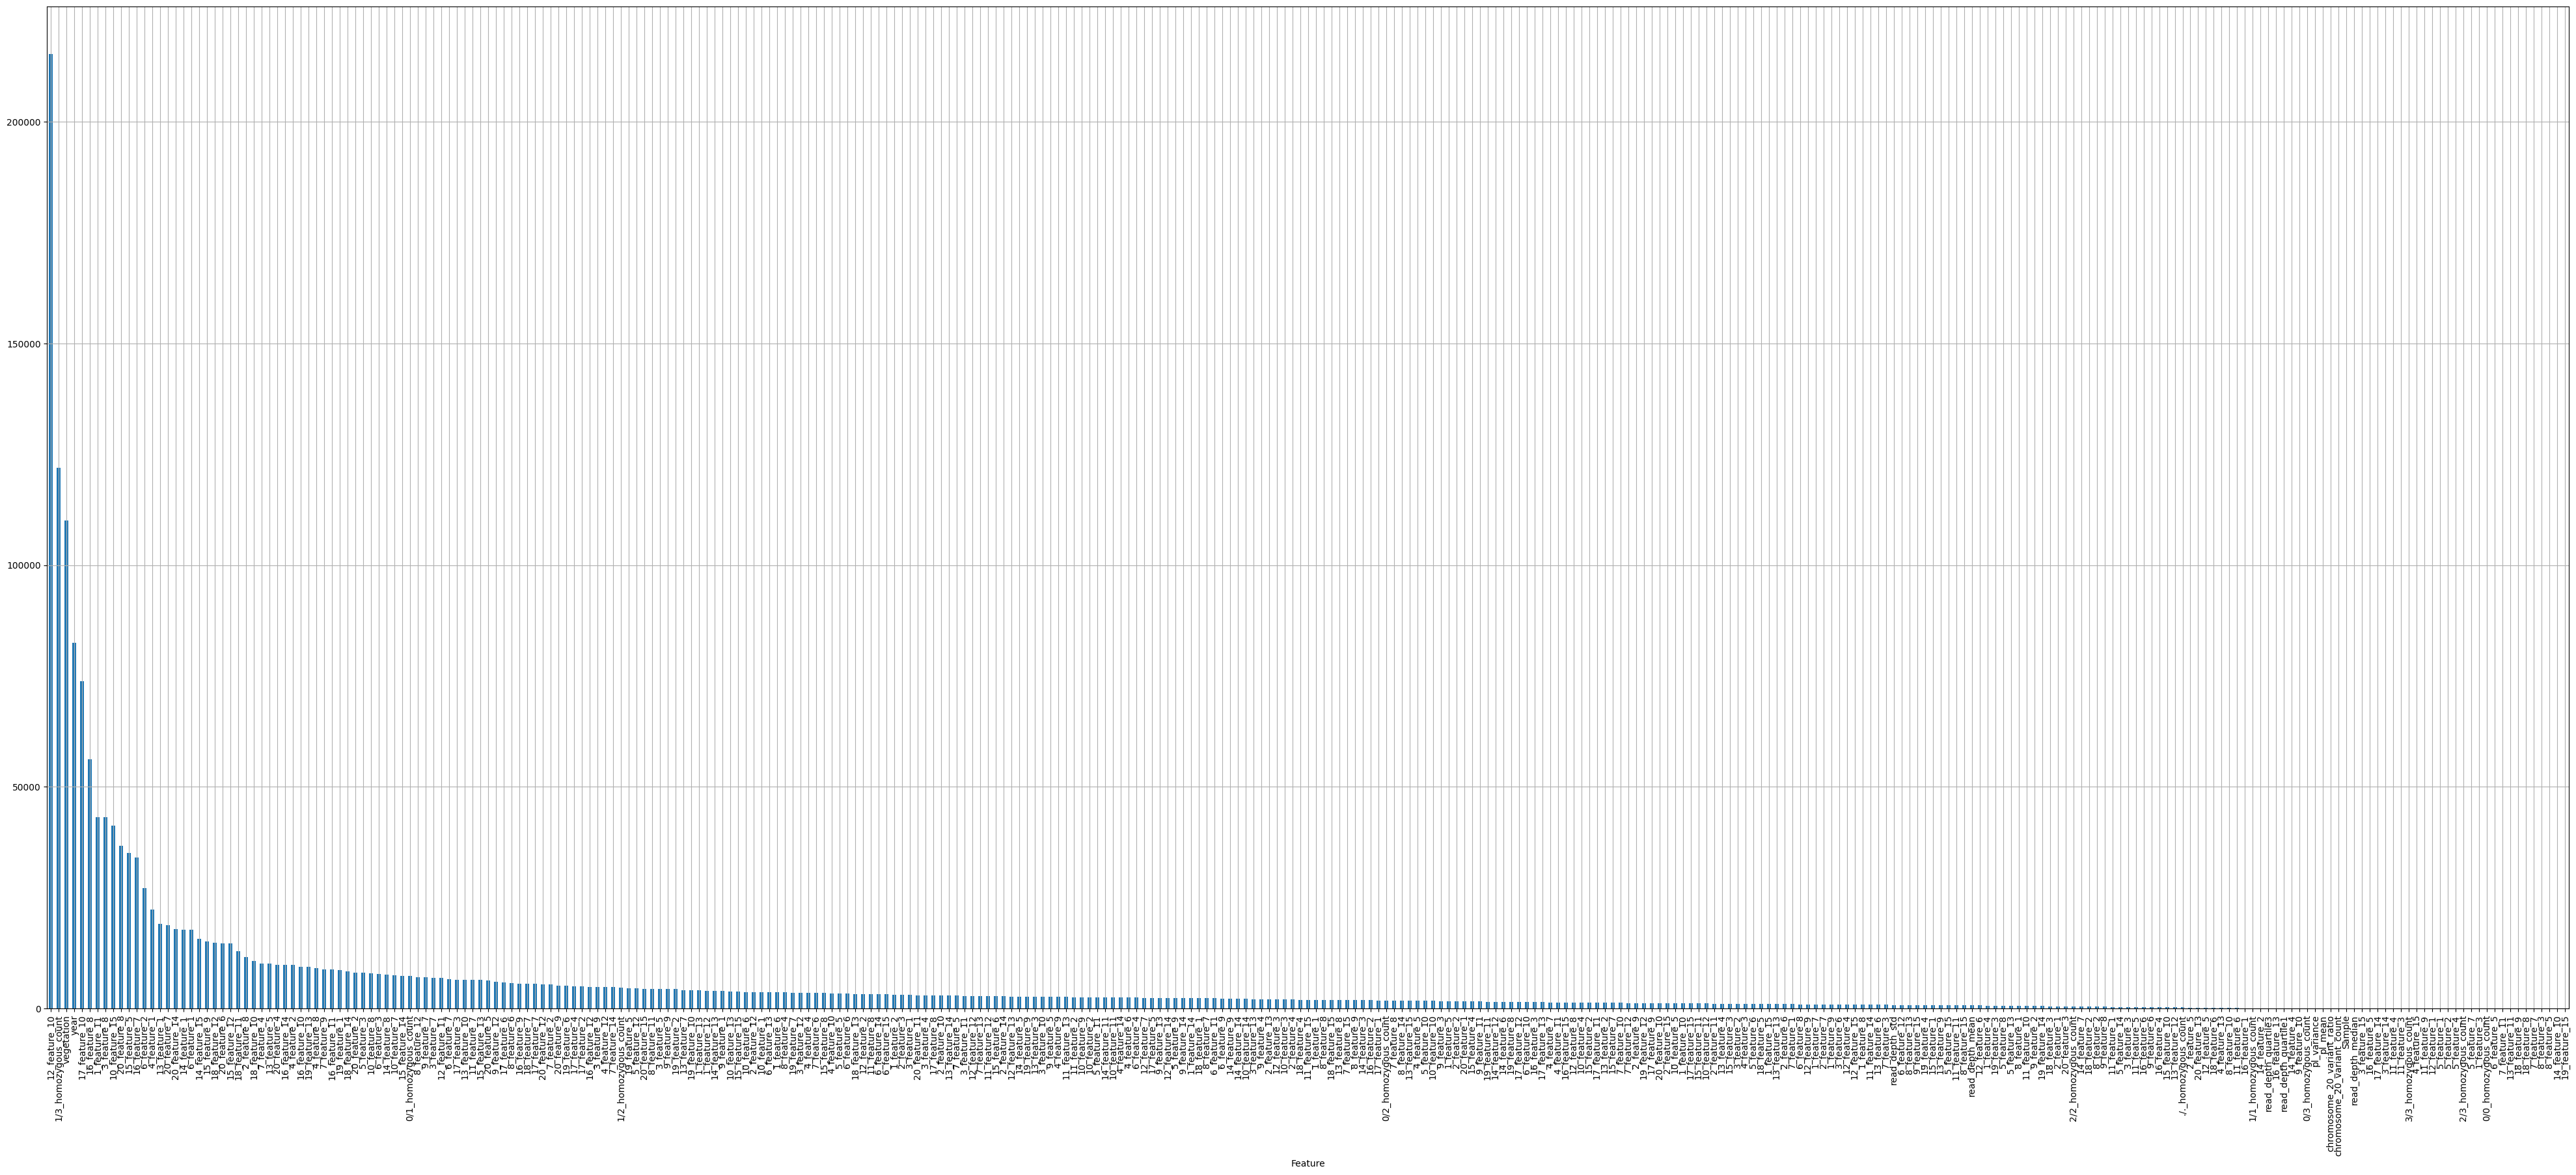

In [19]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 2. Обучение с погодными данными (версия 1)

In [20]:
weather_features = pd.read_csv('/kaggle/input/dataset-rshb/weather_by_year.csv')
weather_features.head(2)

year  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0  2019           22.463526            12.18052            17.616291   
1  2020           22.364832            12.08967            17.512083   

   apparent_temperature_max  apparent_temperature_min  \
0                 21.224934                 10.787100   
1                 20.761883                 10.323973   

   apparent_temperature_mean  daylight_duration  sunshine_duration  \
0                  16.414839           54460.37          41273.824   
1                  15.946865           54403.72          41456.970   

   wind_speed_10m_max  ...  diffuse_radiation_max  \
0           17.137775  ...                  407.0   
1           18.681967  ...                  379.0   

   direct_normal_irradiance_max  global_tilted_irradiance_max  \
0                     884.26984                         881.0   
1                     881.84530                         877.0   

   terrestrial_radiation_max  shortwave_radiation_instant_max  \
0                  1164.0810                        879.45734   
1                  1164.1654                        876.27750   

   direct_radiation_instant_max  diffuse_radiation_instant_max  \
0                      770.6482                      415.89212   
1                      762.8529                      386.75308   

   direct_normal_irradiance_instant_max  global_tilted_irradiance_instant_max  \
0                             884.26984                             879.45734   
1                             881.84520                             876.27750   

   terrestrial_radiation_instant_max  
0                          1162.5675  
1                          1162.6553  

[2 rows x 71 columns]

In [21]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   diffuse_radiation_max  direct_normal_irradiance_max  \
0                  376.0                      869.5877   
1                  376.0                      869.5877   

   global_tilted_irradiance_max  terrestrial_radiation_max  \
0                         869.0                  1164.1378   
1                         869.0                  1164.1378   

   shortwave_radiation_instant_max  direct_radiation_instant_max  \
0                         863.0618                      719.8193   
1                         863.0618                      719.8193   

   diffuse_radiation_instant_max  direct_normal_irradiance_instant_max  \
0                      364.74194                              869.5877   
1                      364.74194                              869.5877   

   global_tilted_irradiance_instant_max  terrestrial_radiation_instant_max  
0                              863.0618                          1162.2426  
1                              863.0618                          1162.2426  

[2 rows x 114 columns]

## Разделим эмбеддинги на отдельные фичи

In [22]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [23]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [24]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [25]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[17:59:32] Stdout logging level is INFO.
[17:59:32] Task: reg

[17:59:32] Start automl preset with listed constraints:
[17:59:32] - time: 36000.00 seconds
[17:59:32] - CPU: 4 cores
[17:59:32] - memory: 16 GB

[17:59:32] Train data shape: (359, 394)

[17:59:32] Layer 1 train process start. Time left 35999.60 secs
[17:59:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:59:37] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.22415839489006872
[17:59:37] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[17:59:37] Time left 35994.70 secs

[17:59:38] Selector_LightGBM fitting and predicting completed
[17:59:38] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[17:59:44] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.2204260044492078
[17:59:44] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[17:59:44] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8076.57 secs
[18:01:37] Hyperparameters optimization for L

## Посмотрим на итоговый ансамбль

In [26]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.36140 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.37062 * (7 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.05517 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.21281 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [27]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.2450774809348184
TRAIN out-of-fold mape-score: 0.10313505626724108
TRAIN out-of-fold mae-score: 10.312257049475539


## Создадим отчет

In [28]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather1')
automl_rd = RD(automl)

In [29]:
!ls tabularAutoML_model_report_weather1 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

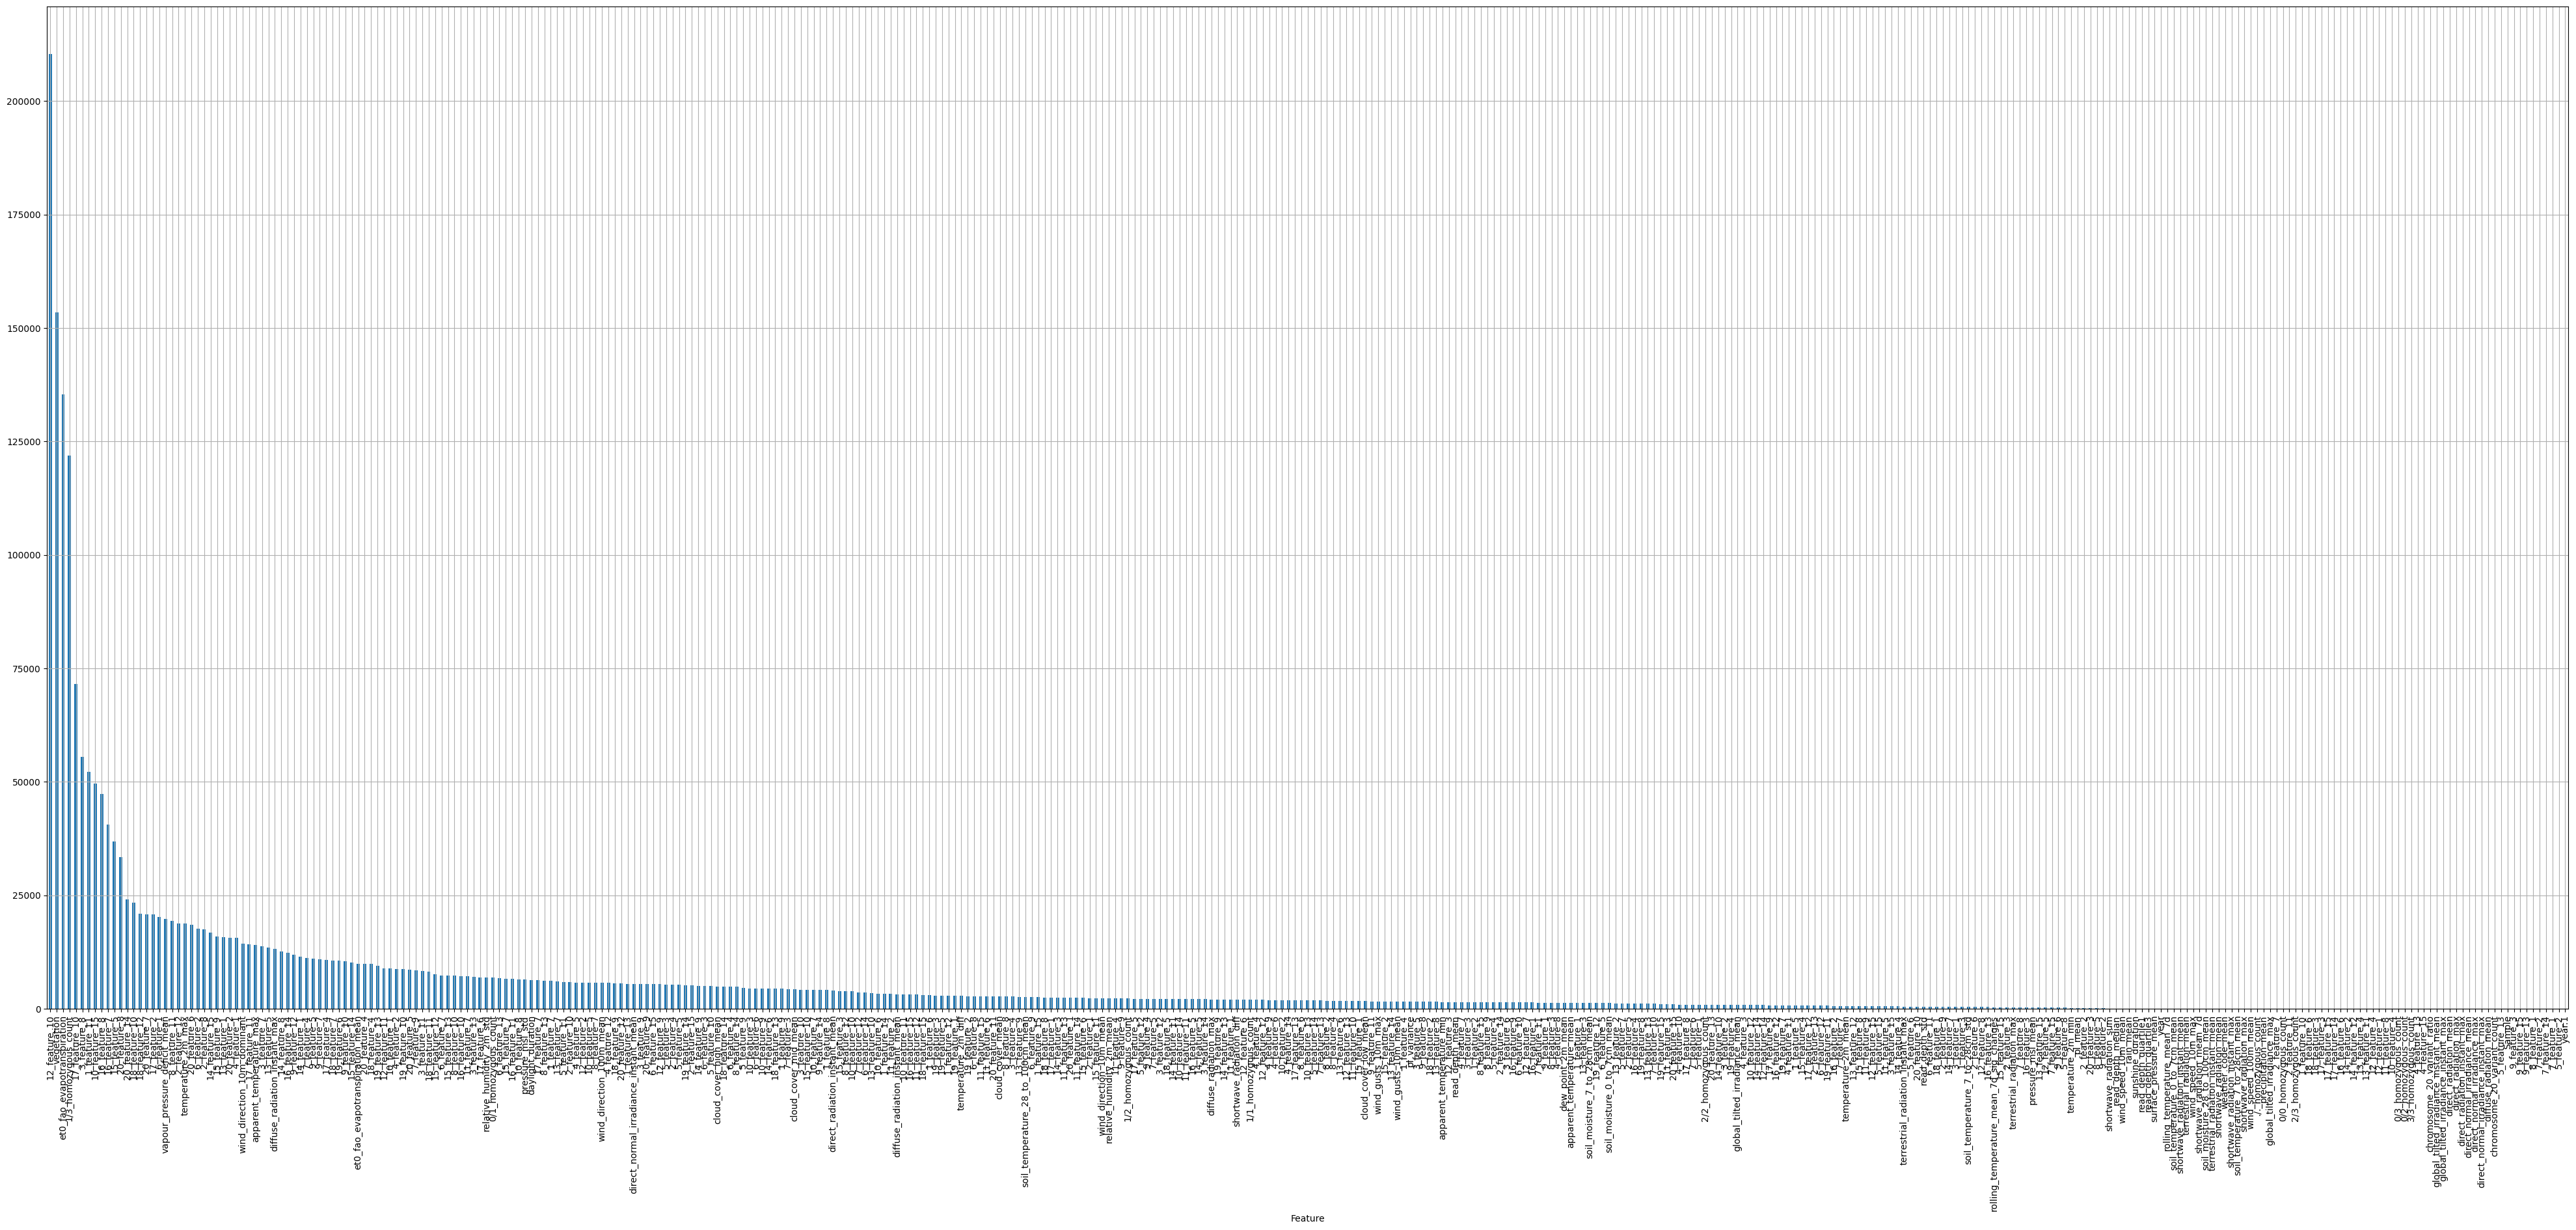

In [30]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 3. Обучение с погодными данными (версия 2)

In [31]:
weather_features = pd.read_csv('/kaggle/input/dataset-rshb/weather_by_year_v2.csv')
weather_features.head(2)

year  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0  2019           22.357153           12.248004            17.590923   
1  2020           22.093102           12.040160            17.320866   

   apparent_temperature_max  apparent_temperature_min  \
0                 21.007662                 10.772452   
1                 20.570436                 10.227975   

   apparent_temperature_mean  daylight_duration  sunshine_duration  \
0                  16.315070           54583.35           40736.69   
1                  15.777227           54526.10           40749.79   

   wind_speed_10m_max  ...  diffuse_radiation_max  \
0           18.013605  ...                  417.0   
1           19.198004  ...                  381.0   

   direct_normal_irradiance_max  global_tilted_irradiance_max  \
0                      885.8309                         879.0   
1                      883.6256                         874.0   

   terrestrial_radiation_max  shortwave_radiation_instant_max  \
0                  1160.9762                        877.54956   
1                  1161.0609                        873.36530   

   direct_radiation_instant_max  diffuse_radiation_instant_max  \
0                     768.72943                      425.48828   
1                     760.05505                      389.04240   

   direct_normal_irradiance_instant_max  global_tilted_irradiance_instant_max  \
0                             885.83080                             877.54956   
1                             883.62555                             873.36530   

   terrestrial_radiation_instant_max  
0                          1159.5826  
1                          1159.6711  

[2 rows x 71 columns]

In [32]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   diffuse_radiation_max  direct_normal_irradiance_max  \
0                  367.0                     850.05743   
1                  367.0                     850.05743   

   global_tilted_irradiance_max  terrestrial_radiation_max  \
0                         862.0                  1170.4559   
1                         862.0                  1170.4559   

   shortwave_radiation_instant_max  direct_radiation_instant_max  \
0                         868.3553                     720.33624   
1                         868.3553                     720.33624   

   diffuse_radiation_instant_max  direct_normal_irradiance_instant_max  \
0                       368.0831                             850.05743   
1                       368.0831                             850.05743   

   global_tilted_irradiance_instant_max  terrestrial_radiation_instant_max  
0                              868.3553                          1170.5146  
1                              868.3553                          1170.5146  

[2 rows x 114 columns]

In [33]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [34]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [35]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [36]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:11:06] Stdout logging level is INFO.
[18:11:06] Task: reg

[18:11:06] Start automl preset with listed constraints:
[18:11:06] - time: 36000.00 seconds
[18:11:06] - CPU: 4 cores
[18:11:06] - memory: 16 GB

[18:11:06] Train data shape: (359, 394)

[18:11:07] Layer 1 train process start. Time left 35999.59 secs
[18:11:07] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:11:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.22477383563650188
[18:11:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:11:13] Time left 35993.84 secs

[18:11:14] Selector_LightGBM fitting and predicting completed
[18:11:14] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:11:20] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.21739459673153516
[18:11:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:11:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8069.69 secs
[18:13:11] Hyperparameters optimization for 

## Посмотрим на итоговый ансамбль

In [37]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.43575 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.08034 * (7 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.05864 * (7 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.18931 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.23595 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [38]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.2409619983645268
TRAIN out-of-fold mape-score: 0.10332857124390496
TRAIN out-of-fold mae-score: 10.323264204359985


## Cоздадим отчет

In [39]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather2')
automl_rd = RD(automl)

In [40]:
!ls tabularAutoML_model_report_weather2 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

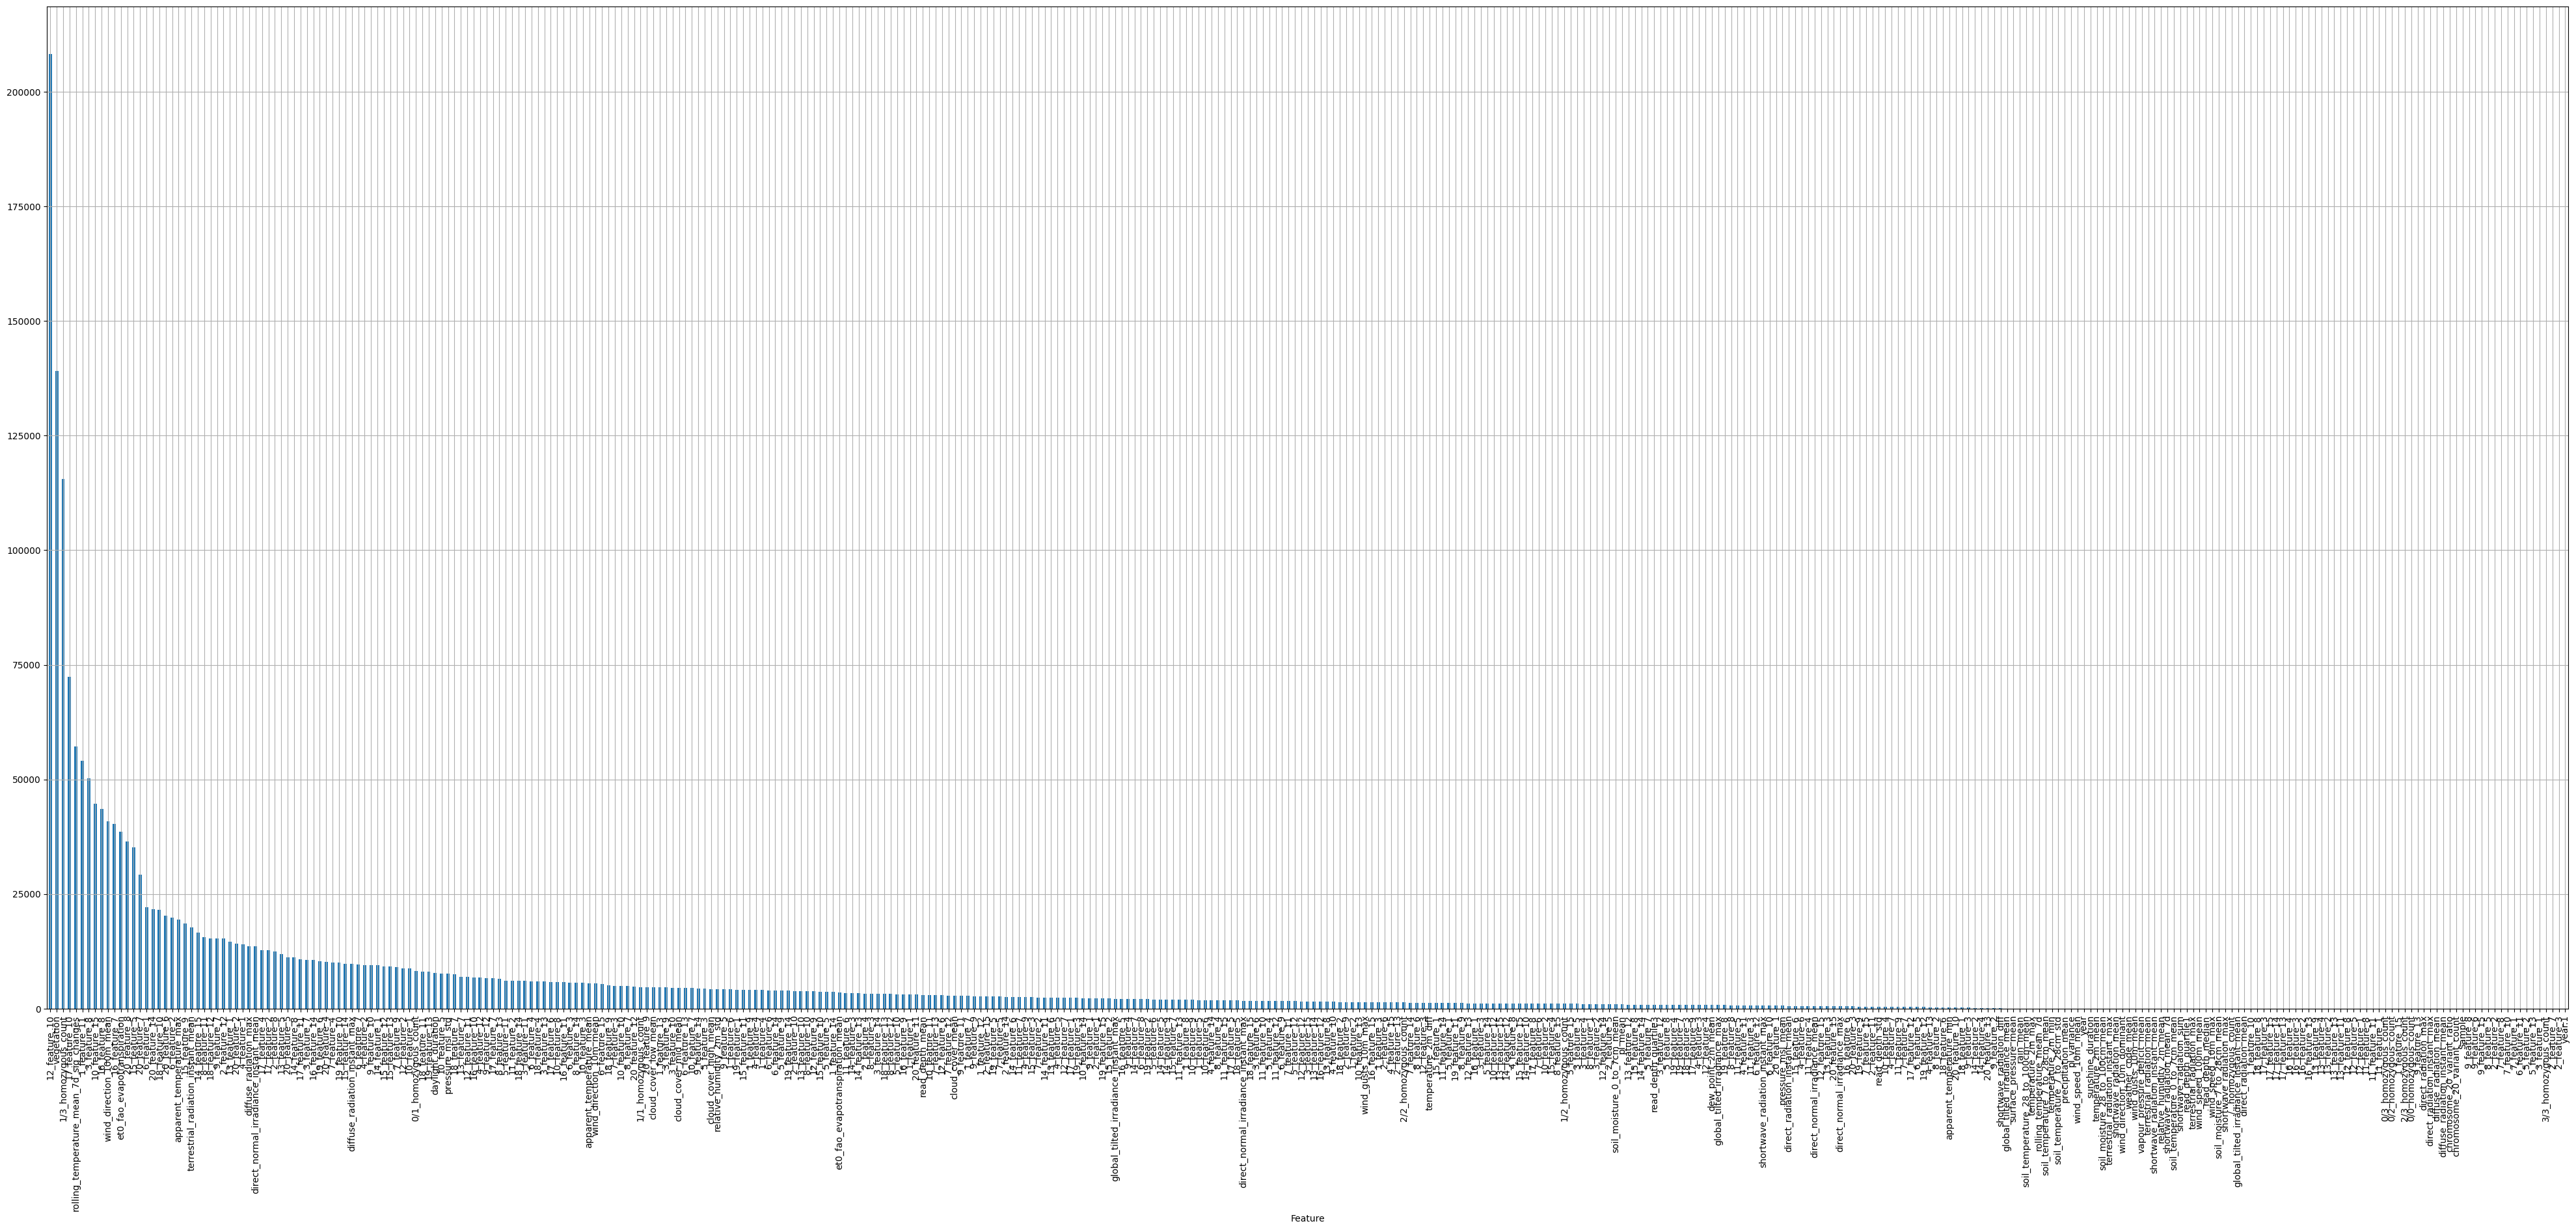

In [41]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 4. Обучение с погодными данными (версия 3)

In [42]:
weather_features = pd.read_csv('/kaggle/input/dataset-rshb/combined_weather.csv')
weather_features=weather_features.rename(columns={'Unnamed: 0':'year'})
weather_features.head(2)

year  apparent_temperature_max  apparent_temperature_mean  \
0  2019                 21.224934                  16.413099   
1  2020                 20.761883                  15.951975   

   apparent_temperature_min  cloud_cover_avg_mean  cloud_cover_high_mean  \
0                 10.787100             24.329958              34.045137   
1                 10.323973             24.574581              32.827292   

   cloud_cover_low_mean  cloud_cover_mean  cloud_cover_mid_mean  \
0             14.111715         51.737614             24.866816   
1             14.206756         51.639822             26.745853   

   daylight_duration  ...  wind_direction_100m_mean  \
0           54460.37  ...                 183.59917   
1           54403.72  ...                 184.09337   

   wind_direction_10m_dominant  wind_direction_10m_mean  \
0                    183.77129                182.85529   
1                    183.70137                182.61075   

   wind_direction_diff_mean  wind_gusts_10m_max  wind_gusts_10m_mean  \
0                  0.767384           34.745884            22.821655   
1                  1.496524           37.381176            25.487306   

   wind_speed_100m_mean  wind_speed_10m_max  wind_speed_10m_mean  year.1  
0             18.379313           17.137775            11.172885  2019.0  
1             20.787554           18.681967            12.776931  2020.0  

[2 rows x 93 columns]

In [43]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   wind_direction_100m_mean  wind_direction_10m_dominant  \
0                 177.93608                    177.83066   
1                 177.93608                    177.83066   

   wind_direction_10m_mean  wind_direction_diff_mean  wind_gusts_10m_max  \
0                177.48395                  0.447362           34.404705   
1                177.48395                  0.447362           34.404705   

   wind_gusts_10m_mean  wind_speed_100m_mean  wind_speed_10m_max  \
0             23.40089             18.914072           16.251787   
1             23.40089             18.914072           16.251787   

   wind_speed_10m_mean  year.1  
0            11.399781  2015.0  
1            11.399781  2015.0  

[2 rows x 136 columns]

## Разделим эмбеддинги на отдельные фичи

In [44]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

emdedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [45]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [46]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [47]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:18:15] Stdout logging level is INFO.
[18:18:15] Task: reg

[18:18:15] Start automl preset with listed constraints:
[18:18:15] - time: 36000.00 seconds
[18:18:15] - CPU: 4 cores
[18:18:15] - memory: 16 GB

[18:18:15] Train data shape: (359, 416)

[18:18:16] Layer 1 train process start. Time left 35999.56 secs
[18:18:16] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:18:20] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.22291728030419133
[18:18:20] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:18:20] Time left 35994.83 secs

[18:18:21] Selector_LightGBM fitting and predicting completed
[18:18:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:18:27] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.21366849423880752
[18:18:27] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:18:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8074.67 secs
[18:21:07] Hyperparameters optimization for 

## Посмотрим на итоговый ансамбль

In [48]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.48888 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.20739 * (7 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.30374 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [49]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.23812274493231056
TRAIN out-of-fold mape-score: 0.10320495557062223
TRAIN out-of-fold mae-score: 10.31144064050531


## Создадим отчет

In [50]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather3')
automl_rd = RD(automl)

In [51]:
!ls tabularAutoML_model_report_weather3 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

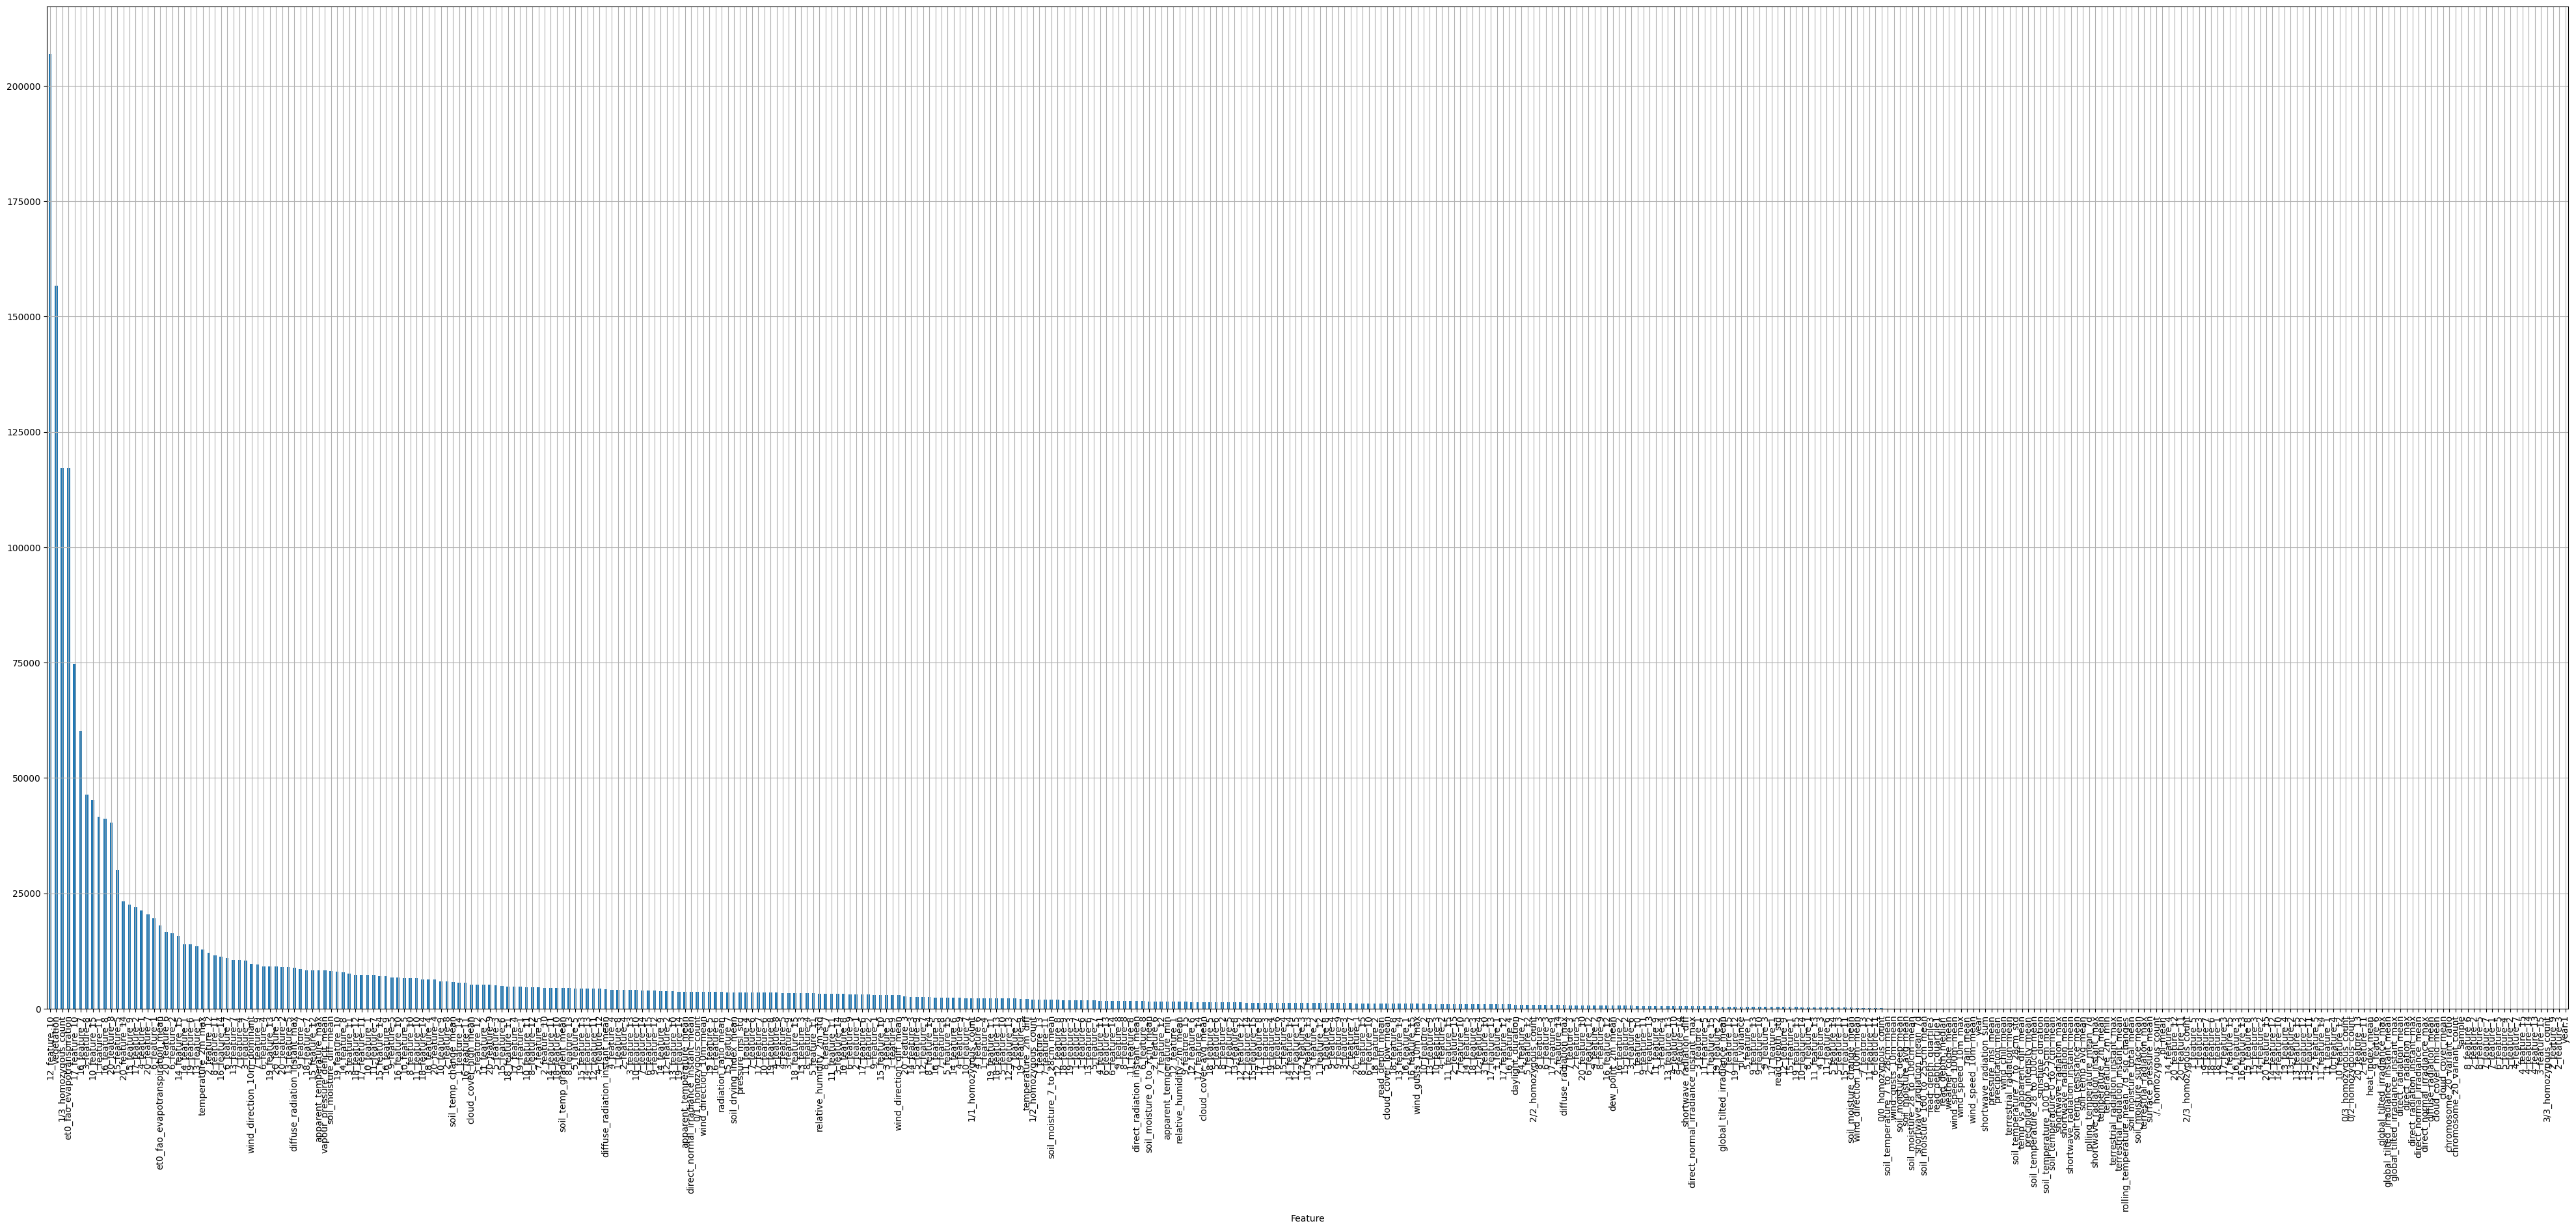

In [52]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 5. Обучение с сезонными погодными данными (версия 4)

In [53]:
weather_features = pd.read_csv('/kaggle/input/combined228/combined_weather_v2.csv')
weather_features.head(2)

year  apparent_temperature_max  apparent_temperature_mean  \
0  2019                 21.224934                  16.413099   
1  2020                 20.761883                  15.951975   

   apparent_temperature_min  cloud_cover_avg_mean  cloud_cover_high_mean  \
0                 10.787100             24.329958              34.045137   
1                 10.323973             24.574581              32.827292   

   cloud_cover_low_mean  cloud_cover_mean  cloud_cover_mid_mean  \
0             14.111715         51.737614             24.866816   
1             14.206756         51.639822             26.745853   

   daylight_duration  ...  wind_direction_100m_mean  \
0           54460.37  ...                 183.59917   
1           54403.72  ...                 184.09337   

   wind_direction_10m_dominant  wind_direction_10m_mean  \
0                    183.77129                182.85529   
1                    183.70137                182.61075   

   wind_direction_diff_mean  wind_gusts_10m_max  wind_gusts_10m_mean  \
0                  0.767384           34.745884            22.821655   
1                  1.496524           37.381176            25.487306   

   wind_speed_100m_mean  wind_speed_10m_max  wind_speed_10m_mean  year.1  
0             18.379313           17.137775            11.172885  2019.0  
1             20.787554           18.681967            12.776931  2020.0  

[2 rows x 158 columns]

In [54]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   wind_direction_100m_mean  wind_direction_10m_dominant  \
0                 177.93608                    177.83066   
1                 177.93608                    177.83066   

   wind_direction_10m_mean  wind_direction_diff_mean  wind_gusts_10m_max  \
0                177.48395                  0.447362           34.404705   
1                177.48395                  0.447362           34.404705   

   wind_gusts_10m_mean  wind_speed_100m_mean  wind_speed_10m_max  \
0             23.40089             18.914072           16.251787   
1             23.40089             18.914072           16.251787   

   wind_speed_10m_mean  year.1  
0            11.399781  2015.0  
1            11.399781  2015.0  

[2 rows x 201 columns]

## Разделим эмбеддинги на отдельные фичи

In [55]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [56]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [57]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [58]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:28:38] Stdout logging level is INFO.
[18:28:38] Task: reg

[18:28:38] Start automl preset with listed constraints:
[18:28:38] - time: 36000.00 seconds
[18:28:38] - CPU: 4 cores
[18:28:38] - memory: 16 GB

[18:28:38] Train data shape: (359, 481)

[18:28:38] Layer 1 train process start. Time left 35999.53 secs
[18:28:39] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:28:44] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.220216373576818
[18:28:44] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:28:44] Time left 35994.16 secs

[18:28:45] Selector_LightGBM fitting and predicting completed
[18:28:45] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:28:50] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.21374546308790265
[18:28:50] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:28:50] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8076.41 secs
[18:30:49] Hyperparameters optimization for Lv

## Посмотрим на итоговый ансамбль

In [59]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.40769 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.28464 * (7 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.23919 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.06848 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [60]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.23880682943987674
TRAIN out-of-fold mape-score: 0.10328972288740637
TRAIN out-of-fold mae-score: 10.296626141476432


## Создадим отчет

In [61]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather4')
automl_rd = RD(automl)

In [62]:
!ls tabularAutoML_model_report_weather4 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

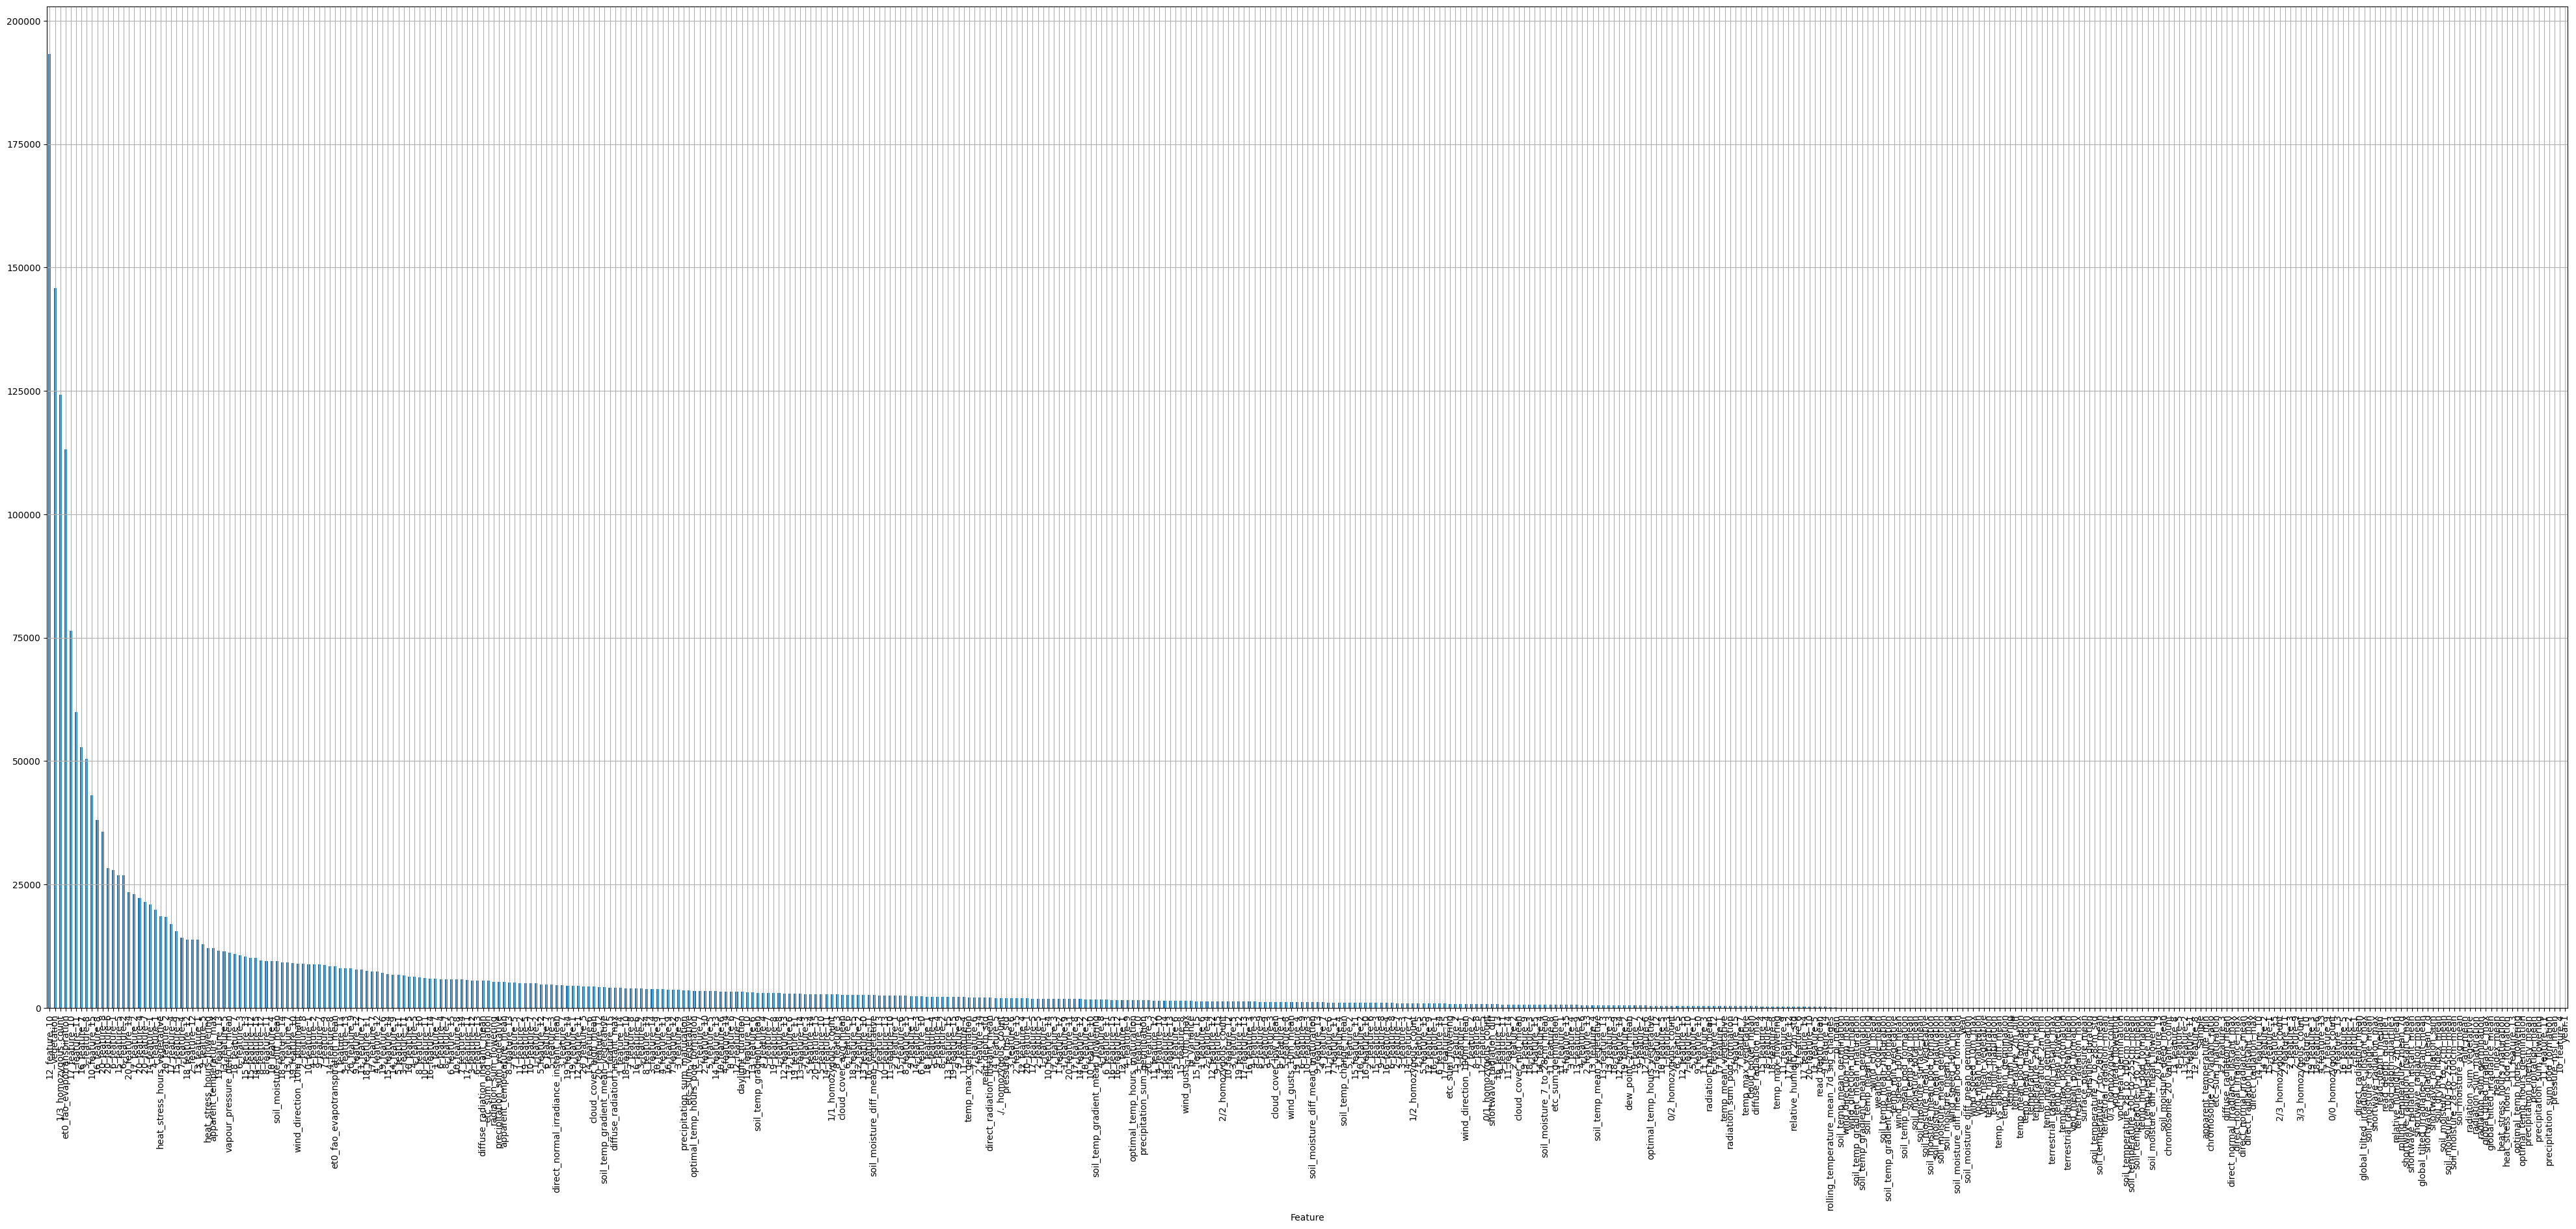

In [63]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 6. Обучение с сезонными погодными данными (версия 5)

In [64]:
weather_features = pd.read_csv('/kaggle/input/growing-new/growing_season_v1.csv')
weather_features.head(2)

year  temp_mean_emergence  temp_max_emergence  temp_min_emergence  \
0  2015             6.855135           16.587500             -3.2125   
1  2016            11.988122           19.387499              2.6375   

   soil_temp_mean_emergence  soil_moisture_mean_emergence  \
0                  5.065820                      0.362573   
1                  7.016286                      0.379307   

   precipitation_sum_emergence  radiation_sum_emergence  vpd_mean_emergence  \
0                     8.500001                  48655.0            0.360206   
1                    15.099999                  45761.0            0.435195   

   etc_sum_emergence  ...  soil_moisture_mean_ripening  \
0          24.427181  ...                     0.204934   
1          27.236141  ...                     0.207789   

   precipitation_sum_ripening  radiation_sum_ripening  vpd_mean_ripening  \
0                         1.1                 83917.0           1.199490   
1                        29.3                 85354.0           1.155035   

   etc_sum_ripening  heat_stress_hours_ripening  optimal_temp_hours_ripening  \
0         68.435196                          12                          304   
1         66.857704                          24                          337   

   soil_temp_gradient_mean_ripening  soil_moisture_diff_mean_ripening  \
0                          7.422853                         -0.040071   
1                          8.940859                         -0.081572   

   period_length_days_ripening  
0                           15  
1                           15  

[2 rows x 103 columns]

In [65]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   soil_moisture_mean_ripening  precipitation_sum_ripening  \
0                     0.204934                         1.1   
1                     0.204934                         1.1   

   radiation_sum_ripening  vpd_mean_ripening  etc_sum_ripening  \
0                 83917.0            1.19949         68.435196   
1                 83917.0            1.19949         68.435196   

   heat_stress_hours_ripening  optimal_temp_hours_ripening  \
0                          12                          304   
1                          12                          304   

   soil_temp_gradient_mean_ripening  soil_moisture_diff_mean_ripening  \
0                          7.422853                         -0.040071   
1                          7.422853                         -0.040071   

   period_length_days_ripening  
0                           15  
1                           15  

[2 rows x 146 columns]

## Разделим эмбеддинги на отдельные фичи

In [66]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [67]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [68]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [69]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:37:34] Stdout logging level is INFO.
[18:37:34] Task: reg

[18:37:34] Start automl preset with listed constraints:
[18:37:34] - time: 36000.00 seconds
[18:37:34] - CPU: 4 cores
[18:37:34] - memory: 16 GB

[18:37:34] Train data shape: (359, 426)

[18:37:35] Layer 1 train process start. Time left 35999.58 secs
[18:37:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:37:39] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.2225962501065195
[18:37:39] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:37:39] Time left 35995.11 secs

[18:37:40] Selector_LightGBM fitting and predicting completed
[18:37:41] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:37:46] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.2155267585513061
[18:37:46] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:37:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8076.98 secs
[18:39:26] Hyperparameters optimization for Lv

## Посмотрим на итоговый ансамбль

In [70]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.31490 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.37158 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31351 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [71]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.24933865423215662
TRAIN out-of-fold mape-score: 0.10281307381035522
TRAIN out-of-fold mae-score: 10.254326100468967


## Создадим отчет

In [72]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather5')
automl_rd = RD(automl)

In [73]:
!ls tabularAutoML_model_report_weather5 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

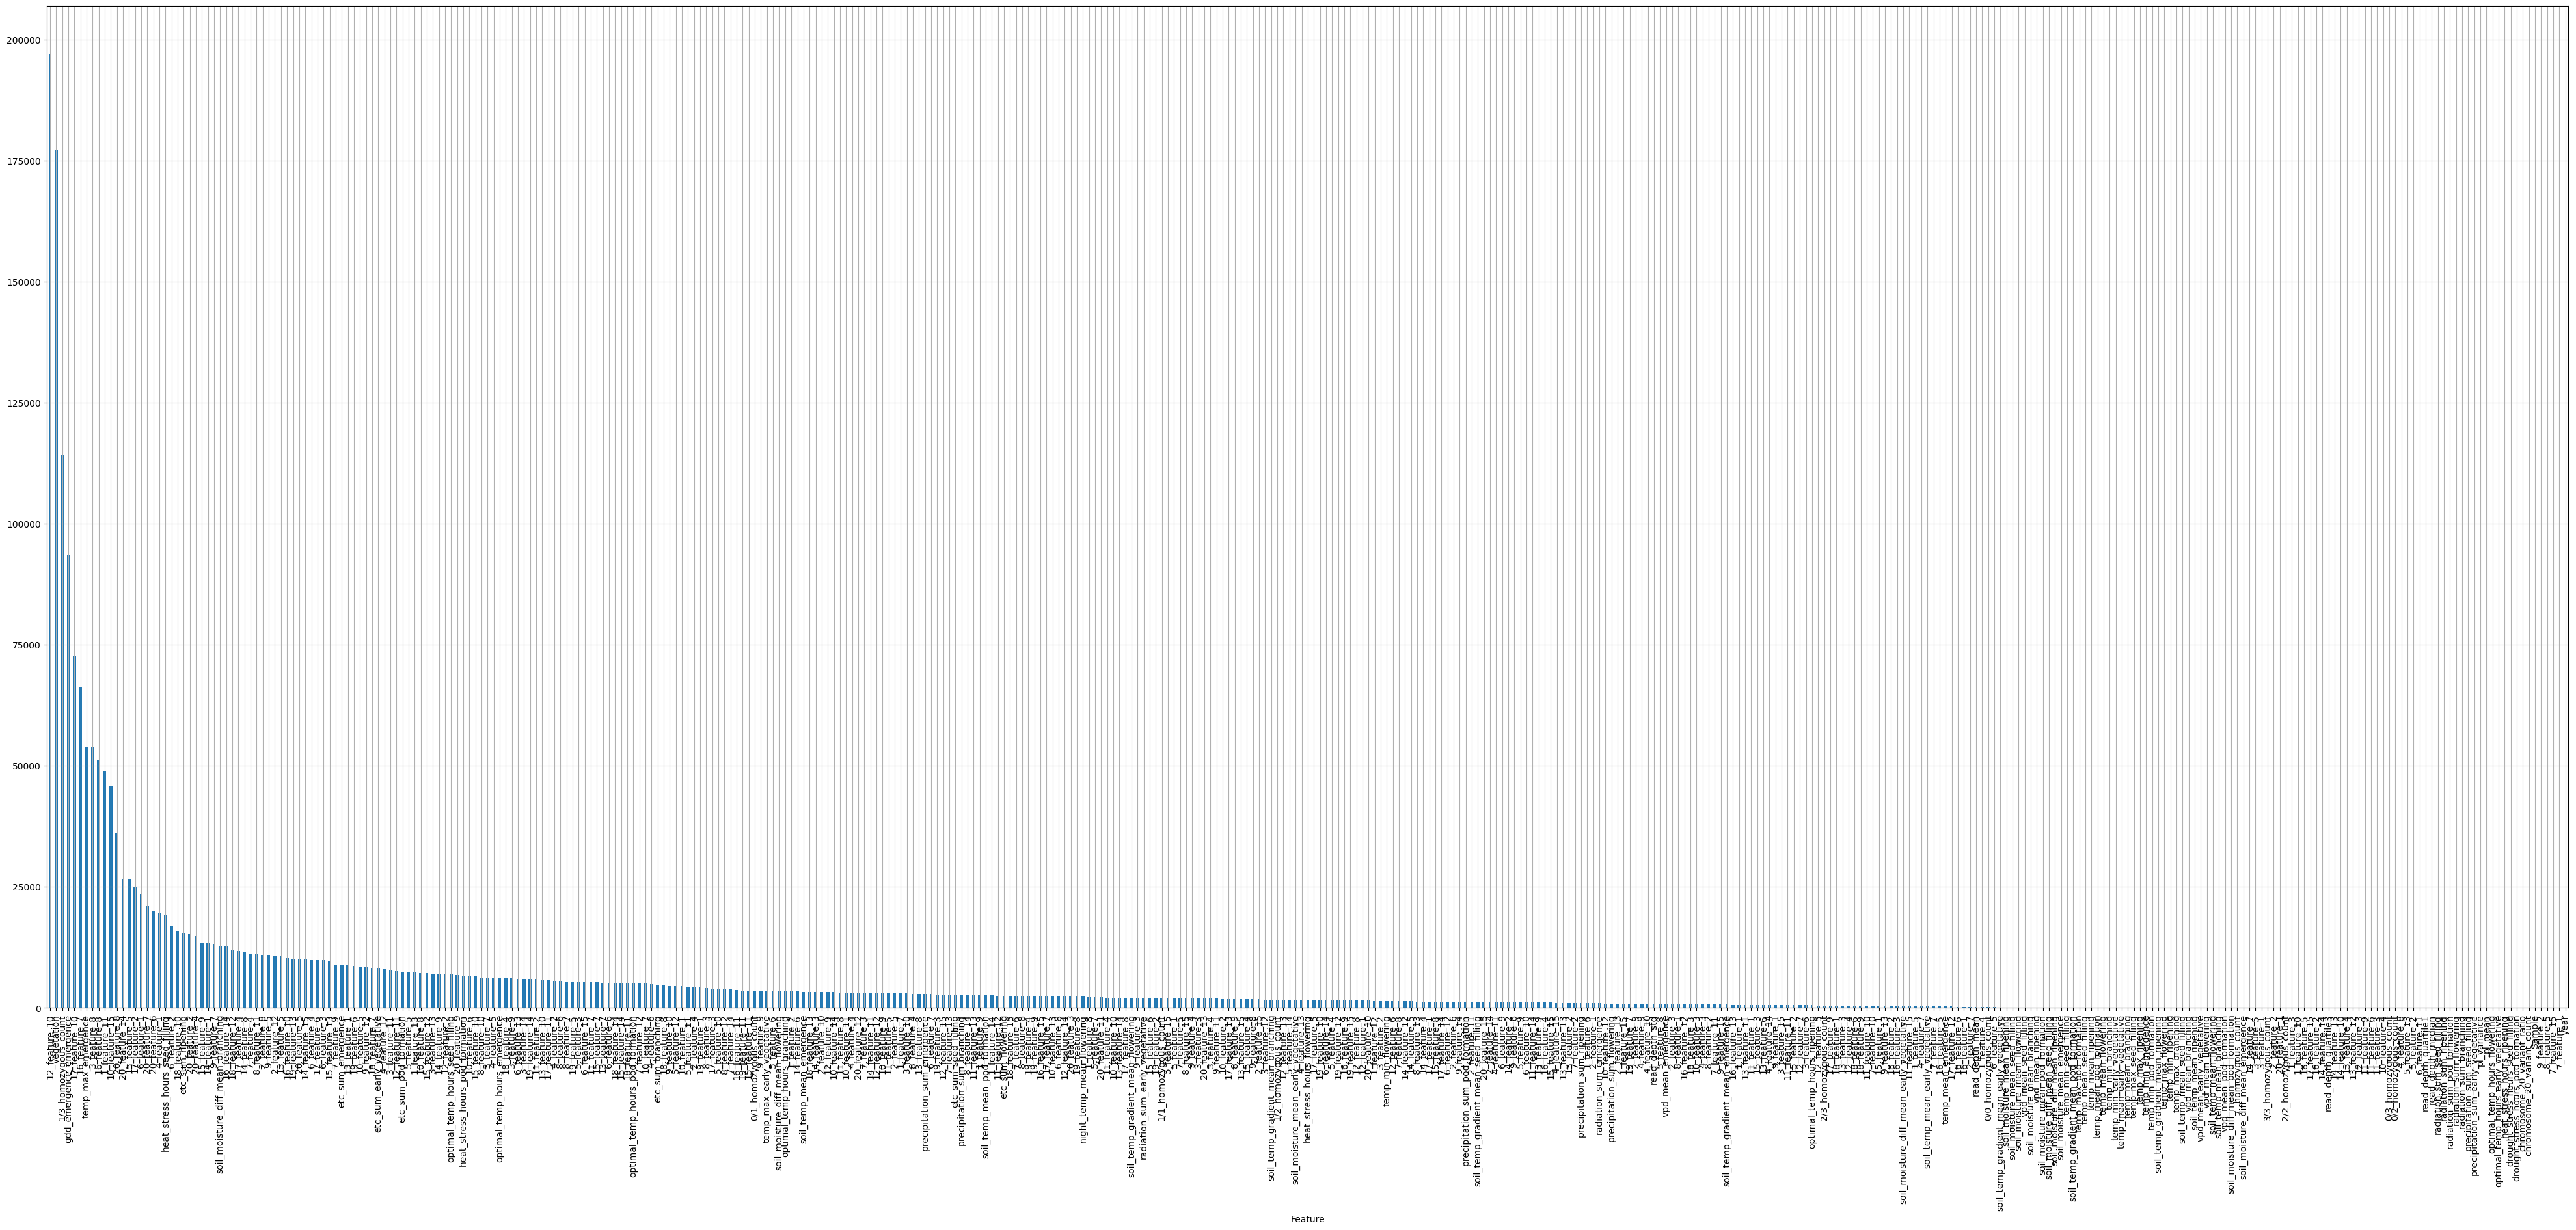

In [74]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)

# 7. Обучение с сезонными погодными данными (версия 6)

In [75]:
weather_features = pd.read_csv('/kaggle/input/growing-new/growing_season_v2.csv')
weather_features.head(2)

year  temp_mean_emergence  temp_max_emergence  temp_min_emergence  \
0  2015             6.947845             35.6375             35.6375   
1  2016            11.506344             17.7875              4.6875   

   soil_temp_mean_emergence  soil_moisture_mean_emergence  \
0                  5.063746                      0.360758   
1                  7.074514                      0.380277   

   precipitation_sum_emergence  radiation_sum_emergence  vpd_mean_emergence  \
0                     9.496786             56892.680637            0.371080   
1                    20.073370             51866.634751            0.424829   

   etc_sum_emergence  ...  soil_moisture_mean_ripening  \
0          29.087452  ...                     0.213135   
1          30.665181  ...                     0.214312   

   precipitation_sum_ripening  radiation_sum_ripening  vpd_mean_ripening  \
0                   33.776348           248509.966130           1.070973   
1                   69.596911           240448.574981           1.076841   

   etc_sum_ripening  heat_stress_hours_ripening  optimal_temp_hours_ripening  \
0        198.908707                   23.980316                   924.307117   
1        194.696370                   60.357837                  1035.635791   

   soil_temp_gradient_mean_ripening  soil_moisture_diff_mean_ripening  \
0                          6.498354                         -0.031128   
1                          7.713122                         -0.075084   

   period_weight_sum_ripening  
0                 1114.012385  
1                 1114.012385  

[2 rows x 103 columns]

In [76]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

Sample  0/0_homozygous_count  0/1_homozygous_count  1/1_homozygous_count  \
0  PS000026               16814.0                4712.0                7452.0   
1  PS000027               21268.0                5224.0                9381.0   

   ./._homozygous_count  1/2_homozygous_count  0/2_homozygous_count  \
0                9898.0                  32.0                  26.0   
1                2985.0                  57.0                  15.0   

   2/2_homozygous_count  1/3_homozygous_count  2/3_homozygous_count  ...  \
0                   2.0                   2.0                   1.0  ...   
1                   8.0                   0.0                   2.0  ...   

   soil_moisture_mean_ripening  precipitation_sum_ripening  \
0                     0.213135                   33.776348   
1                     0.213135                   33.776348   

   radiation_sum_ripening  vpd_mean_ripening  etc_sum_ripening  \
0            248509.96613           1.070973        198.908707   
1            248509.96613           1.070973        198.908707   

   heat_stress_hours_ripening  optimal_temp_hours_ripening  \
0                   23.980316                   924.307117   
1                   23.980316                   924.307117   

   soil_temp_gradient_mean_ripening  soil_moisture_diff_mean_ripening  \
0                          6.498354                         -0.031128   
1                          6.498354                         -0.031128   

   period_weight_sum_ripening  
0                 1114.012385  
1                 1114.012385  

[2 rows x 146 columns]

## Разделим эмбеддинги на отдельные фичи

In [77]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [78]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [79]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [80]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:45:52] Stdout logging level is INFO.
[18:45:52] Task: reg

[18:45:52] Start automl preset with listed constraints:
[18:45:52] - time: 36000.00 seconds
[18:45:52] - CPU: 4 cores
[18:45:52] - memory: 16 GB

[18:45:52] Train data shape: (359, 426)

[18:45:52] Layer 1 train process start. Time left 35999.57 secs
[18:45:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:45:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.22281881151046856
[18:45:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:45:57] Time left 35995.33 secs

[18:45:58] Selector_LightGBM fitting and predicting completed
[18:45:58] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:46:04] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.2134267366555206
[18:46:04] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:46:04] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8064.29 secs
[18:48:10] Hyperparameters optimization for L

## Посмотрим на итоговый ансамбль

In [81]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.47472 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05134 * (7 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.23269 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.24125 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [82]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.23631424509459853
TRAIN out-of-fold mape-score: 0.10341207963244455
TRAIN out-of-fold mae-score: 10.329049219328049


## Создадим отчет

In [83]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather6')
automl_rd = RD(automl)

In [84]:
!ls tabularAutoML_model_report_weather6 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

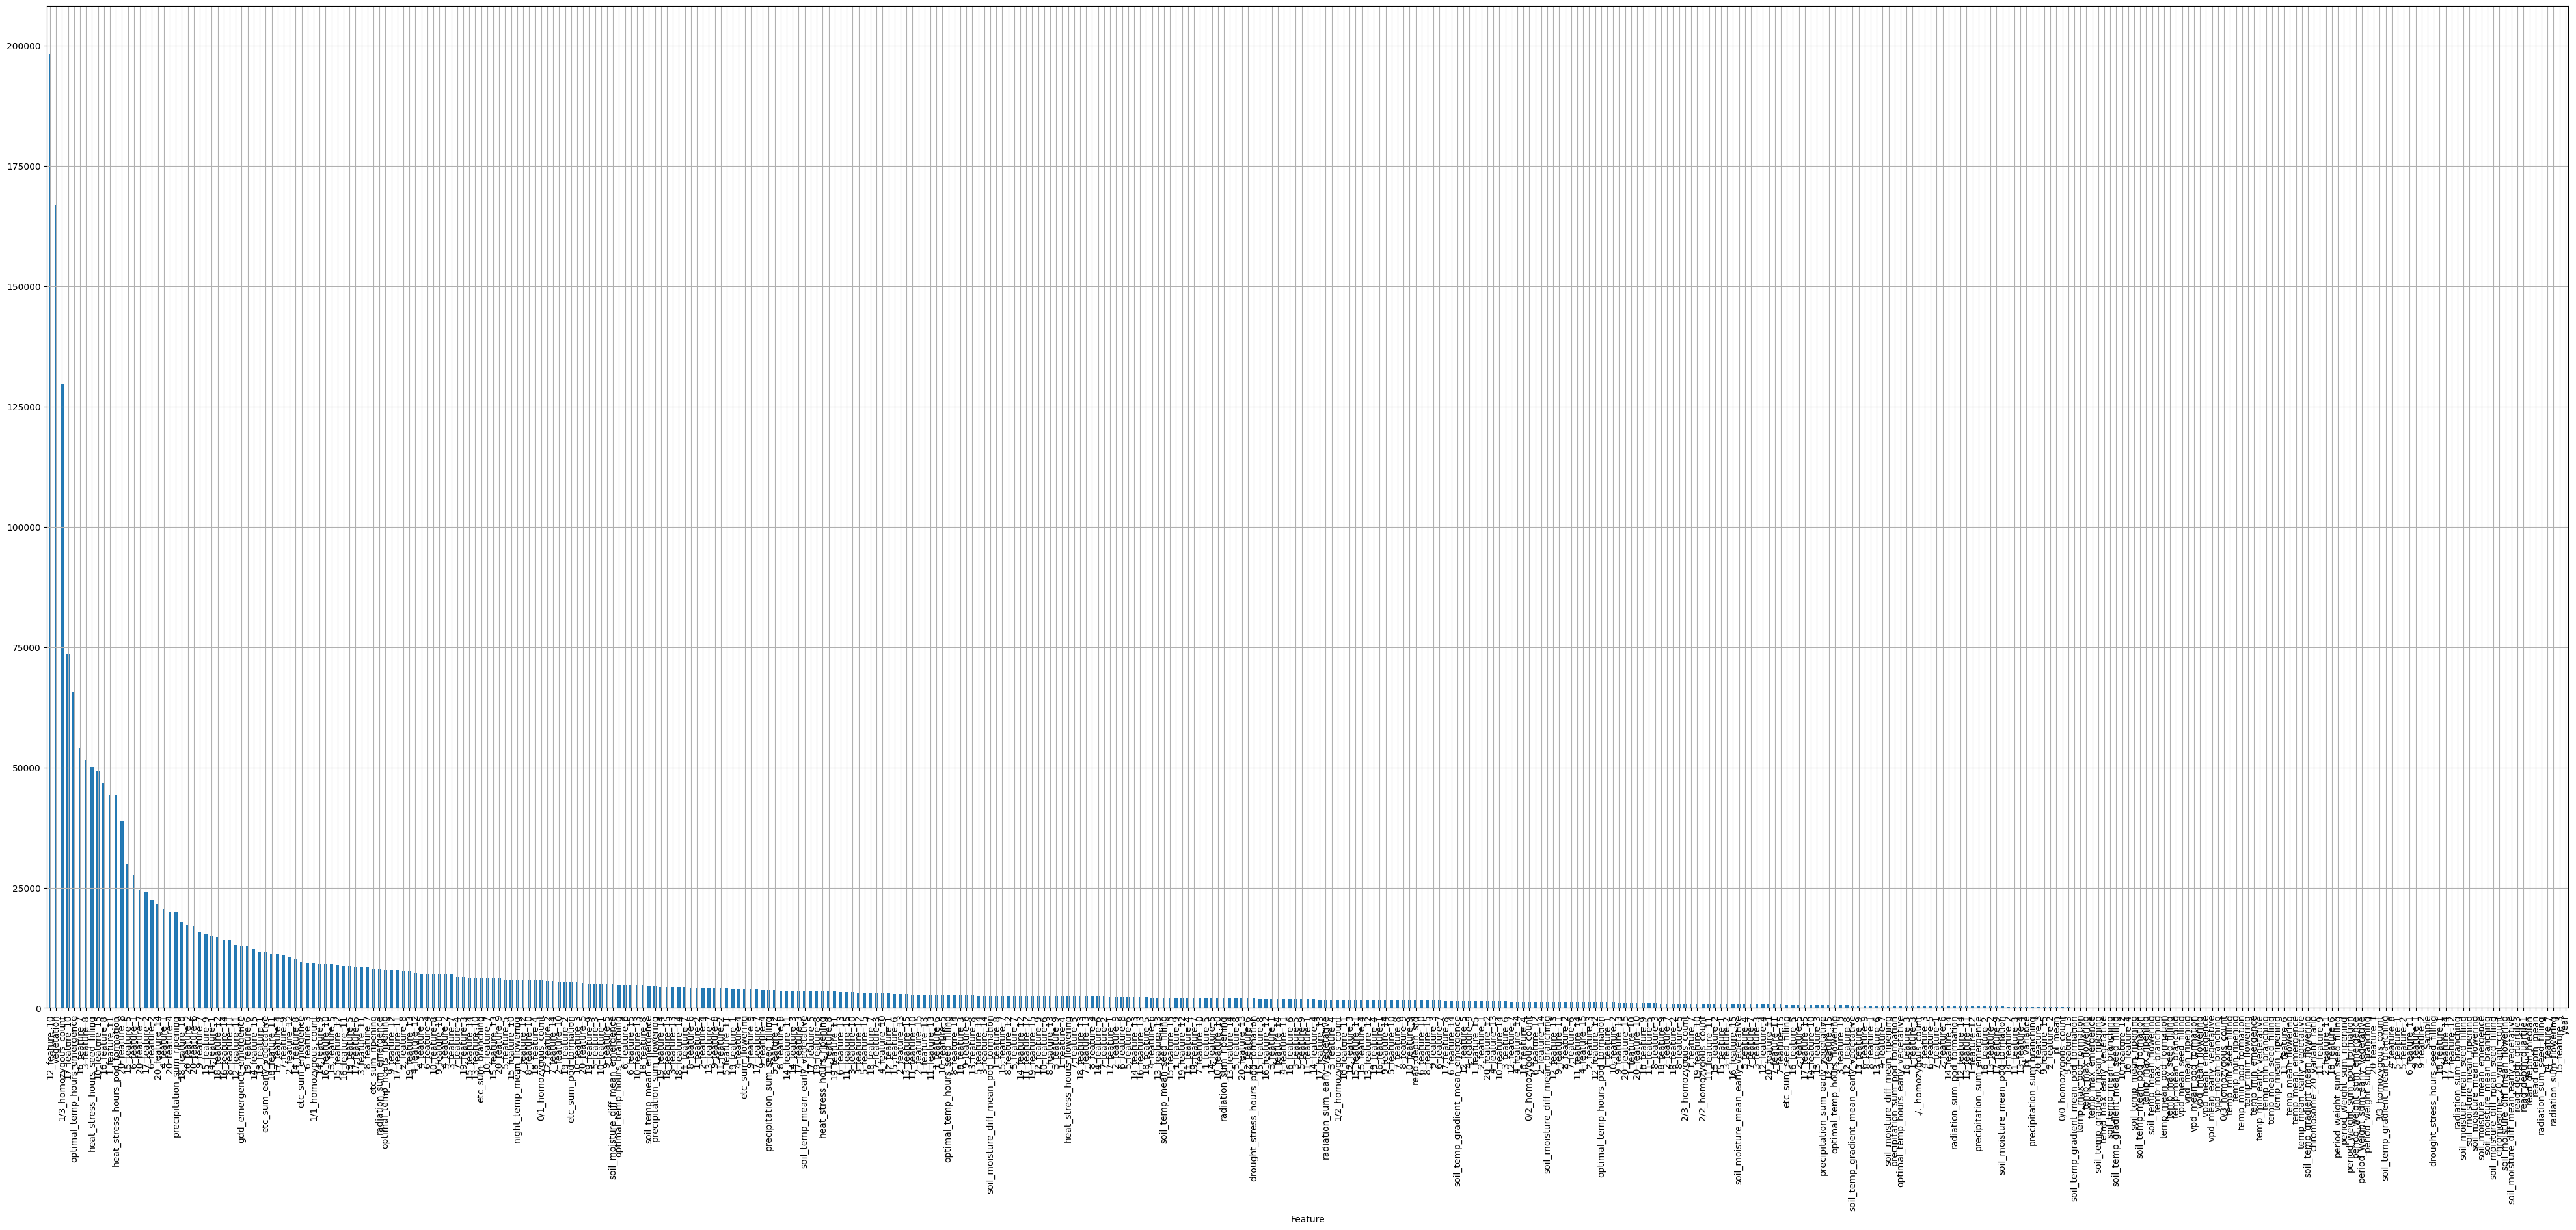

In [85]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)